# ALIGNN Optimization Visualizations

In [1]:
import os
from pprint import pprint
import json

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

### Configure ALIGNN output Directory:
Set the paths below to reflect the directory structure on your system:

In [2]:
PTABLE_CSV = './data/periodictable/PeriodicTable.csv'

ALIGNN_OPTIMIZATION_DIR = './data/structures/alignn_optimization'

BEST_ALIGNN_OUTPUT_DIR = './data/structures/alignn_optimization/384features_output'

### Configure Matplotlib:

In [3]:
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

# This sets the pdf rendering to be pdflatex-compatible:
plt.rcParams.update({
    'pgf.texsystem' : 'pdflatex'
})

# use seaborn plot style:
plt.style.use('seaborn')

# Hyperparameter Tuning Visualization:
The most important parameters we are trying to control here are the number of ALIGNN + CGNN layers and the number of hidden features in these layers.

In [4]:
optimization_contents = os.listdir(ALIGNN_OPTIMIZATION_DIR)

print('Contents of alignn optimization directory:')
pprint(optimization_contents)

Contents of alignn optimization directory:
['128features_output',
 '192features_output',
 '1layer_output',
 '256features_output',
 '2layer_output',
 '320features_output',
 '384features_output',
 '3layer_output',
 '448features_output',
 '4layer_output',
 '512features_output',
 '5layer_output',
 '64features_output']


In [5]:
def get_model_optimization_data(dir_map, dir_path):
    """ parses model optimization data from a dir_map of the form:
        
        { <parameter value> : <alignn output dir> , ... }
        
        the <alignn output dir> are subdirectories found in dir_path.
    """
    opt_history = {}
    opt_test_predictions = {}
    for n, subdir_name in dir_map.items():
        train_file = os.path.join(dir_path, subdir_name, 'history_train.json')
        test_file = os.path.join(dir_path, subdir_name, 'history_val.json')
        pred_file = os.path.join(dir_path, subdir_name, './prediction_results_test_set.csv')
        with open(train_file, 'r') as f:
            train_data = json.loads(f.read())
        with open(test_file, 'r') as f:
            test_data = json.loads(f.read())
        opt_test_predictions[n] = pd.read_csv(pred_file)
        opt_history[n] = (train_data, test_data)
        
    return opt_history, opt_test_predictions

In [6]:
# These should associate the number of layers with each of the models listed above:
LAYER_OPTIMIZATION_DIRS = {
    1 : '1layer_output',
    2 : '2layer_output',
    3 : '3layer_output',
    4 : '4layer_output',
    5 : '5layer_output'
}

FEATURE_OPTIMIZATION_DIRS = {
    64  : '64features_output',
    128 : '128features_output',
    192 : '192features_output',
    256 : '256features_output',
    320 : '320features_output',
    384 : '384features_output',
    448 : '448features_output',
    512 : '512features_output'
}

FEATURES_SHOWN_CONVERGENCE_SUBSET = [ 64, 128, 256, 512]


layers_history, layers_test_predictions = \
    get_model_optimization_data(
        LAYER_OPTIMIZATION_DIRS, 
        ALIGNN_OPTIMIZATION_DIR)

features_history, features_test_predictions = \
    get_model_optimization_data(
        FEATURE_OPTIMIZATION_DIRS, 
        ALIGNN_OPTIMIZATION_DIR)

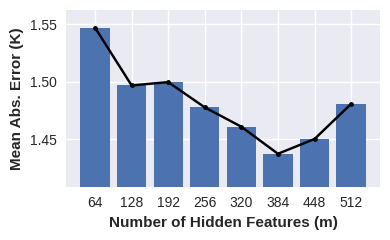

In [7]:
features_test_maes = {
    n : np.mean(np.abs(df['target'] - df['prediction']))
    for n, df in features_test_predictions.items()
}

layers_test_maes = {
    n : np.mean(np.abs(df['target'] - df['prediction']))
    for n, df in layers_test_predictions.items()
}

features_N = np.array(list(features_test_maes.keys()))
features_MAEs = np.array([ features_test_maes[n] for n in features_N])

plt.figure(figsize=(4,2.5))
plt.bar(np.arange(len(features_MAEs)),features_MAEs)
plt.plot(np.arange(len(features_MAEs)),features_MAEs, '.-k')
plt.ylim(min(features_MAEs)*0.98,max(features_MAEs)*1.01)
plt.xticks(np.arange(len(features_MAEs)), labels=features_N)
plt.xlabel('Number of Hidden Features (m)', fontweight='bold')
plt.ylabel('Mean Abs. Error (K)', fontweight='bold')
plt.tight_layout()
plt.show()

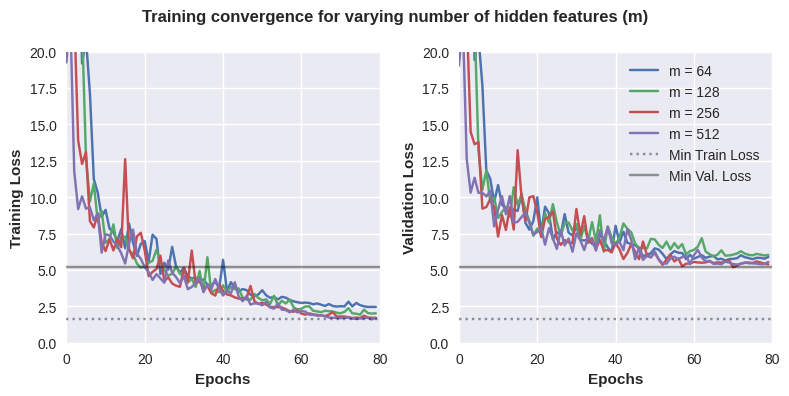

In [8]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
min_train_mae = np.inf
min_val_mae = np.inf

for n in FEATURES_SHOWN_CONVERGENCE_SUBSET:
    (train_data, val_data) = features_history[n]
    train_mae = np.array(train_data['loss'])
    val_mae = np.array(val_data['loss'])
    min_train_mae = min(min_train_mae,np.min(train_mae))
    min_val_mae = min(min_val_mae, np.min(val_mae))
    axs[0].plot(train_mae, label=f'm = {n}')
    axs[1].plot(val_mae, label=f'm = {n}')

n_epochs = 80
for i in range(2):
    axs[i].plot([0,n_epochs],[min_train_mae]*2, ':k', alpha=0.4,
                label=f'Min Train Loss')
    axs[i].plot([0,n_epochs],[min_val_mae]*2,  'k', alpha=0.4,
               label=f'Min Val. Loss')

axs[0].set_xlabel('Epochs', fontweight='bold')
axs[1].set_xlabel('Epochs', fontweight='bold')
axs[0].set_ylabel('Training Loss', fontweight='bold')
axs[1].set_ylabel('Validation Loss', fontweight='bold')
axs[1].legend(ncol=1)
axs[0].set_ylim(0,20)
axs[1].set_ylim(0,20)
axs[0].set_xlim(0,n_epochs)
axs[1].set_xlim(0,n_epochs)
fig.suptitle('Training convergence for varying number of hidden features (m)',
             fontweight='bold')
plt.tight_layout()
plt.show()

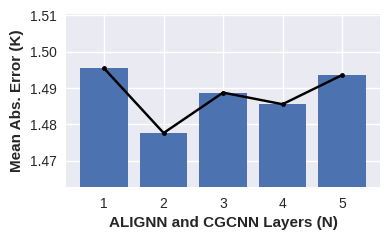

In [9]:
layers_N = np.array(list(layers_test_maes.keys()))
layers_MAEs = np.array([ layers_test_maes[n] for n in layers_N])
plt.figure(figsize=(4,2.5))
plt.bar(np.arange(len(layers_MAEs)),layers_MAEs)
plt.plot(np.arange(len(layers_MAEs)),layers_MAEs, '.-k')
plt.ylim(min(layers_MAEs)*0.99,max(layers_MAEs)*1.01)
plt.xticks(np.arange(len(layers_MAEs)), labels=layers_N)
plt.xlabel('ALIGNN and CGCNN Layers (N)', fontweight='bold')
plt.ylabel('Mean Abs. Error (K)', fontweight='bold')
plt.tight_layout()
    
plt.show()

# Convergence of Optimally Configured Model:

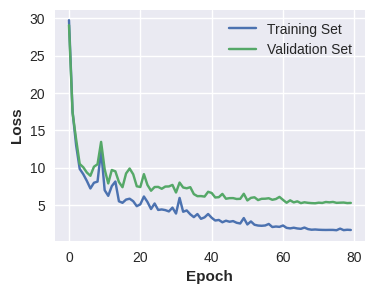

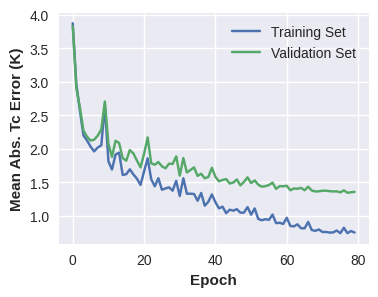

In [10]:
import json

train_file = os.path.join(BEST_ALIGNN_OUTPUT_DIR,
                          'history_train.json')
test_file = os.path.join(BEST_ALIGNN_OUTPUT_DIR,
                          'history_val.json')

with open(train_file, 'r') as f:
    train_data = json.loads(f.read())
with open(test_file, 'r') as f:
    test_data = json.loads(f.read())
    
train_loss = np.array(train_data['loss'])
train_mae = np.array(train_data['mae'])
test_loss = np.array(test_data['loss'])
test_mae = np.array(test_data['mae'])


plt.figure(figsize=(4,3))
plt.plot(train_loss, label='Training Set')
plt.plot(test_loss, label='Validation Set')
plt.ylabel('Loss', fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.legend()
plt.show()
    
plt.figure(figsize=(4,3))
plt.plot(train_mae, label='Training Set')
plt.plot(test_mae, label='Validation Set')
plt.ylabel('Mean Abs. Tc Error (K)', fontweight='bold')
plt.legend()
plt.xlabel('Epoch', fontweight='bold')
plt.show()

In [11]:
print('Data Tc ranges:')
with open(os.path.join(BEST_ALIGNN_OUTPUT_DIR,'mad'),'r') as f:
    mad_data = dict(
        tuple(l.strip().split(':'))
        for l in f.readlines()
    )
    for k, v in mad_data.items():
        print(f'{k}: {float(v):.3f}')
    

Data Tc ranges:
MAX val: 41.400
MIN val: 0.001
MAD val: 4.666


In [12]:
import pandas as pd
prediction_results = pd.read_csv(
    os.path.join(BEST_ALIGNN_OUTPUT_DIR,
                 './prediction_results_test_set.csv'))

prediction_results['prediction'].apply(lambda x : abs(x))
prediction_results['MAE'] = \
    prediction_results.apply(lambda r : abs(r.target - r.prediction), axis=1)
prediction_results = prediction_results.rename(columns={
    'id':'Formula', 'target':'Actual', 'prediction':'Predicted'})

prediction_results

,Formula,Actual,Predicted,MAE
0,Sr1Pd1.8Rh0.2Ge2.poscar,2.920000,3.372724,0.452724
1,Y1Ni1.98Co0.02B2C1.poscar,14.300000,13.327601,0.972399
2,Mo1Ni1P1.poscar,15.500000,7.453924,8.046076
3,Sr1Ga0.7Si1.3.poscar,3.170000,3.551664,0.381664
4,Ho0.4Dy0.6Ni2B2C1.poscar,5.855000,4.989618,0.865382
...,...,...,...,...
386,Pd0.2Ti0.8.poscar,4.710000,3.364746,1.345254
387,Pd0.04Ir0.96Te2.poscar,2.990000,2.370168,0.619832
388,Li1Ti2O4.poscar,11.872727,10.691801,1.180926
389,Ir0.43Ru0.57.poscar,0.180000,0.253222,0.073222


# Interpreting High-Error Predictions:

In [13]:
prediction_results = \
    prediction_results.sort_values(by='MAE', ascending=False)

error_table = prediction_results[:20].rename(
    columns={
        'Formula':'Formula', 
        'Actual':r'Actual $T_c$ (K)', 
        'Predicted':r'Predicted $T_c$ (K)',
        'MAE' : 'MAE (K)'
    })

error_table['Formula'] = \
    error_table['Formula'].apply(lambda f : os.path.splitext(f)[0])

error_table[:10]

,Formula,Actual $T_c$ (K),Predicted $T_c$ (K),MAE (K)
129,C70,7.000000,21.574533,14.574533
328,B0.048C0.952,6.600000,20.576223,13.976223
19,Be0.8Os0.2,8.600000,-0.190518,8.790518
2,Mo1Ni1P1,15.500000,7.453924,8.046076
78,Si0.2V0.8,7.510000,15.035792,7.525792
230,Ba1Pb0.7Bi0.3O3,11.230000,4.510322,6.719678
130,Ge1Ta3,8.000000,1.309571,6.690429
191,Hf1Ru1P1,11.796667,5.531860,6.264807
281,Ba0.57K0.43Bi1O3,21.200001,27.273771,6.073770
205,Ba1Pb0.78Bi0.22O3,10.300000,4.387381,5.912619


In [14]:
# sort results by mean absolute error (MAE):
prediction_errors = sorted(list(zip(
   prediction_results['MAE'],
   prediction_results['Actual'],
   prediction_results['Predicted'],
   prediction_results['Formula']
)))

In [15]:
import re

def build_formula_regex(elements):
    """ builds a formula parsing regex """
    mass_re = '([0-9]*\.[0-9]+|[0-9]+)'
    elem_re = '(' + '|'.join(elements) + ')'
    return re.compile(elem_re + mass_re)

def parse_formula_tokens(formula, regex):
    """ parses a checmical formula consisting of <elem><mass> pairs"""
    tokens = []
    for match in regex.finditer(formula):
        if match.group(1):
            tokens.append((match.group(1), float(match.group(2))))
        else:
            # assume 1.0 if no mass term:
            tokens.append((match.group(1), 1.0))
    return tokens

ptable_df = pd.read_csv(PTABLE_CSV)
elements = sorted(list(set(ptable_df['Symbol'])))
form_re = build_formula_regex(elements)

# show distribution of prediction errors by alloy "k-arity"
karity_map = {}
for alloy in prediction_errors:
    err, tgt, pred, name = alloy
    formula, _ = os.path.splitext(name)
    tokens = parse_formula_tokens(formula, form_re)
    
    # classify alloy based on karity:
    k = 0
    for (elem, n) in tokens:
        if np.abs(n - np.ceil(n)) > 1e-8:
            k += 1
    
    if k not in karity_map:
        karity_map[k] = []
    karity_map[k].append(alloy)

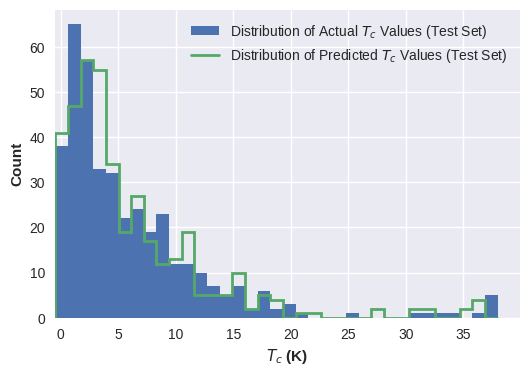

In [16]:
Tc_pred = np.array(prediction_results['Predicted'])
Tc_actual = np.array(prediction_results['Actual'])
Tc_all = np.hstack([Tc_pred, Tc_actual])
Tc_range = (np.min(Tc_all), np.max(Tc_all))

pred_hist, pred_bins = np.histogram(Tc_pred, bins=35, range=Tc_range)
actual_hist, actual_bins = np.histogram(Tc_actual, bins=35, range=Tc_range)


# Check if distribution of test data predictions matches that of the actual values: 
plt.figure(figsize=(6,4))
plt.stairs(actual_hist, actual_bins, linewidth=1.0, fill=True,
           label=r'Distribution of Actual $T_c$ Values (Test Set)')
plt.stairs(pred_hist, pred_bins, linewidth=2.0,
           label=r'Distribution of Predicted $T_c$ Values (Test Set)')
plt.xlabel(r'$T_c$ (K)', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.legend()
plt.xlim(-0.5,None)
plt.show()

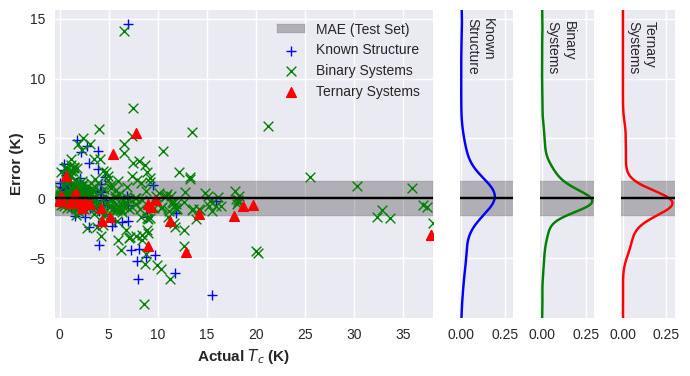

In [17]:
from scipy.stats import gaussian_kde

# Visualize the magnitude of MAE versus T_c:
fig, axs = plt.subplots(1, 4, figsize=(8,4), gridspec_kw={'width_ratios': [7, 1, 1, 1]})
k_colors = ['b', 'g', 'r']
k_markers = ['+', 'x', '^']
k_labels = ['Known Structure','Binary Systems', 'Ternary Systems']
test_mae = np.mean(np.abs(Tc_pred - Tc_actual))

kde_vals = np.linspace(-20,20,4000)
kde_yrange = (-0.01,0.3)

axs[0].fill_between(Tc_range, [-test_mae]*2, [test_mae]*2, color='k', alpha=0.25, label='MAE (Test Set)')
for i, ((k, alloys), (col,mrk,label))  in enumerate(zip(karity_map.items(), 
                                             zip(k_colors,k_markers,k_labels))):
    k_Tc_actual = np.array([ a[1] for a in alloys ])
    k_Tc_pred = np.array([ a[2] for a in alloys ])
    axs[0].scatter(k_Tc_actual, (k_Tc_pred - k_Tc_actual), 
                c=col, marker=mrk, linewidth=1, label=label)
    
    # plot density:
    k_kde = gaussian_kde((k_Tc_pred - k_Tc_actual))
    axs[i+1].fill_between(Tc_range, [-test_mae]*2,[test_mae]*2, color='k', alpha=0.25)
    axs[i+1].plot(k_kde(kde_vals), kde_vals, color=col)
    

axs[0].plot(Tc_range, [0,0], '-k')
axs[0].set_xlim(*Tc_range)

for i, label in enumerate(k_labels):
    axs[i+1].set_ylim(axs[0].get_ylim())
    axs[i+1].set_yticklabels([])
    axs[i+1].set_xlim(kde_yrange)
    axs[i+1].annotate(label.replace(' ', '\n'), (0.1, 0.8), 
                      xycoords='axes fraction', rotation=-90)
    axs[i+1].plot(Tc_range, [0,0], '-k')
    

axs[0].set_xlabel(r'Actual $T_c$ (K)', fontweight='bold')
axs[0].set_ylabel('Error (K)', fontweight='bold')
axs[0].legend(ncol=1)
plt.show()

In [18]:
mad = np.mean(np.abs(Tc_actual - np.mean(Tc_actual)))
mae = np.mean(np.abs(Tc_pred - Tc_actual))
print('MAD:', mad)
print('MAE:', mae)
print('MAD/MAE:', mad/mae)
print('Mean Tc:', np.mean(Tc_actual))

MAD: 4.715611721378065
MAE: 1.4371729283887464
MAD/MAE: 3.281172104086921
Mean Tc: 6.0885800588235295
